[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial4.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial4.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Quantifying Uncertainty in Projections

**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas

**Content reviewers:** Younkap Nina Duplex, Zahra Khodakaramimaghsoud, Sloane Garelick, Peter Ohue, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS, Google DeepMind, and CMIP

# Tutorial Objectives

In the previous tutorial, we constructed a *multi-model ensemble* using data from a diverse set of five CMIP6 models. We showed that the projections differ between models due to their distinct physics, numerics and discretizations. In this tutorial, we will calculate the uncertainty associated with future climate projections by utilizing this variability across CMIP6 models. We will establish a *likely* range of projections as defined by the IPCC. 

By the end of this tutorial, you will be able to 
- apply IPCC confidence levels to climate model data
- quantify the uncertainty associated with CMIP6/ScenarioMIP projections.


# Setup

    



In [13]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

In [14]:
# imports
import time

tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

In [15]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

%matplotlib inline

In [16]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell


def readin_cmip6_to_datatree(facet_dict):
    # open an intake catalog containing the Pangeo CMIP cloud data
    col = intake.open_esm_datastore(
        "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    )

    # from the full `col` object, create a subset using facet search
    cat = col.search(
        source_id=facet_dict['source_id'],
        variable_id=facet_dict['variable_id'],
        member_id=facet_dict['member_id'],
        table_id=facet_dict['table_id'],
        grid_label=facet_dict['grid_label'],
        experiment_id=facet_dict['experiment_id'],
        require_all_on=facet_dict['require_all_on']  # make sure that we only get models which have all of the above experiments
    )

    # convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
    kwargs = dict(
        preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
        xarray_open_kwargs=dict(
            use_cftime=True
        ),  # ensure all datasets use the same time index
        storage_options={
            "token": "anon"
        },  # anonymous/public authentication to google cloud storage
    )

    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)
    
    return dt


def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)


# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]["historical"].ds.sel(time=slice("1950", "1980")).mean()
        dt_out[model] = subtree - ref
    return dt_out


def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ["historical", "ssp126"]:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim="time")

In [17]:
# @title Video 1: Quantifying Uncertainty in Projections

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'YCUsMjDinrA'), ('Bilibili', 'BV1oj411o7bb')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [18]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "u5zrp"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    print(f"If you want to download the slides: {download_link}")
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

Output()

# Section 1: Loading CMIP6 Data from Various Models & Experiments

First, lets load the datasets that we used in the previous tutorial, which spanned 5 models. We will use three CMIP6 experiments, adding the high-emissions (*SSP5-8.5*) future scenario to the *historical* and *SSP1-2.6* experiments used in the last tutorial.



In [23]:
source_ids = ["IPSL-CM6A-LR", "GFDL-ESM4", "ACCESS-CM2", "MPI-ESM1-2-LR", "TaiESM1"]

facet_dict = { "source_id":source_ids,
    "variable_id":"tos",
    "member_id":"r1i1p1f1",
    "table_id":"Omon",
    "grid_label":"gn",
    "experiment_id":["historical", "ssp126", "ssp585"],
    "require_all_on":"source_id"
    }

facet_dict_area = { "source_id":source_ids,
    "variable_id":"areacello",
    "member_id":"r1i1p1f1",
    "table_id":"Ofx",
    "grid_label":"gn",
    "experiment_id":"historical",
    "require_all_on":"source_id"
    }

dt_ensemble = readin_cmip6_to_datatree(facet_dict)
dt_area = readin_cmip6_to_datatree(facet_dict_area)


dt_with_area = DataTree()

for model, subtree in dt.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

for experiment in ["historical", "ssp126", "ssp585"]:
    da = dt_gm["TaiESM1"][experiment].ds.tos

dt_gm_anomaly = datatree_anomaly(dt_gm)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


# Section 2: Quantifying Uncertainty in a CMIP6 Multi-model Ensemble

Let's create a multi-model ensemble containing data from multiple CMIP6 models, which we can use to quantify our confidence in future projected sea surface temperature change under low- and high-emissions scenarios. 

**Your goal in this tutorial is to create a *likely* range of future projected conditions. The IPCC uncertainty language defines the *likely* range as the middle 66% of model results (ignoring the upper 17% and lower 17% of results)**

### Coding Exercise 2.1

Complete the following code to display multi-model ensemble data with IPCC uncertainty bands:


1. The multi-model mean temperature
2. Shading to display the *likely* range of temperatures for the CMIP6 historical and projected data (include both *SSP1-2.6* and *SSP5-8.5*). *da_upper* and *da_lower* are the boundaries of this shaded region



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


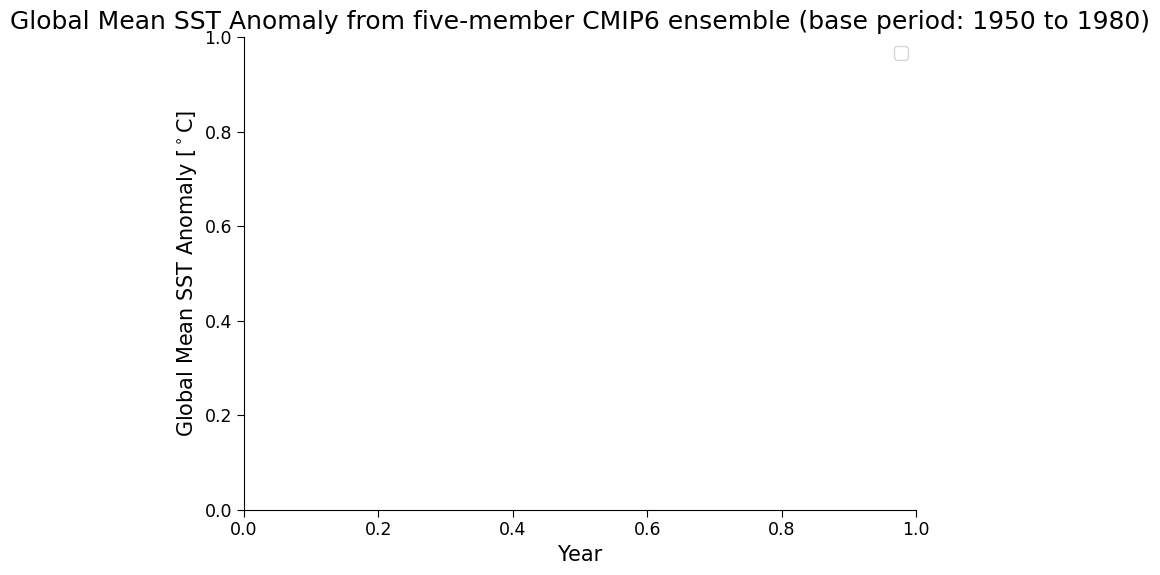

In [24]:
fig, ax = plt.subplots()
for experiment, color in zip(["historical", "ssp126", "ssp585"], ["C0", "C1", "C2"]):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_sst = (
            dt_gm_anomaly[model][experiment]
            .ds.tos.coarsen(time=12)
            .mean()
            .assign_coords(source_id=model)
        )
        datasets.append(
            annual_sst.sel(time=slice(None, "2100")).load()
        )  # the french model has a long running member for ssp126
    da = xr.concat(datasets, dim="source_id", join="override").squeeze()
    # Uncomment the below and fill in the ellipses
    # # Calculate the multi-model mean at each time within each experiment
    # da.mean(...).plot(color=color, label=experiment, ax=ax)
    # x = da.time.data
    # # Calculate the lower bound of the likely range
    # da_lower = da.squeeze().quantile(...)
    # # Calculate the upper bound of the likely range
    # da_upper = da.squeeze().quantile(...)
    # ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)
ax.set_title(
    "Global Mean SST Anomaly from five-member CMIP6 ensemble (base period: 1950 to 1980)"
)
ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

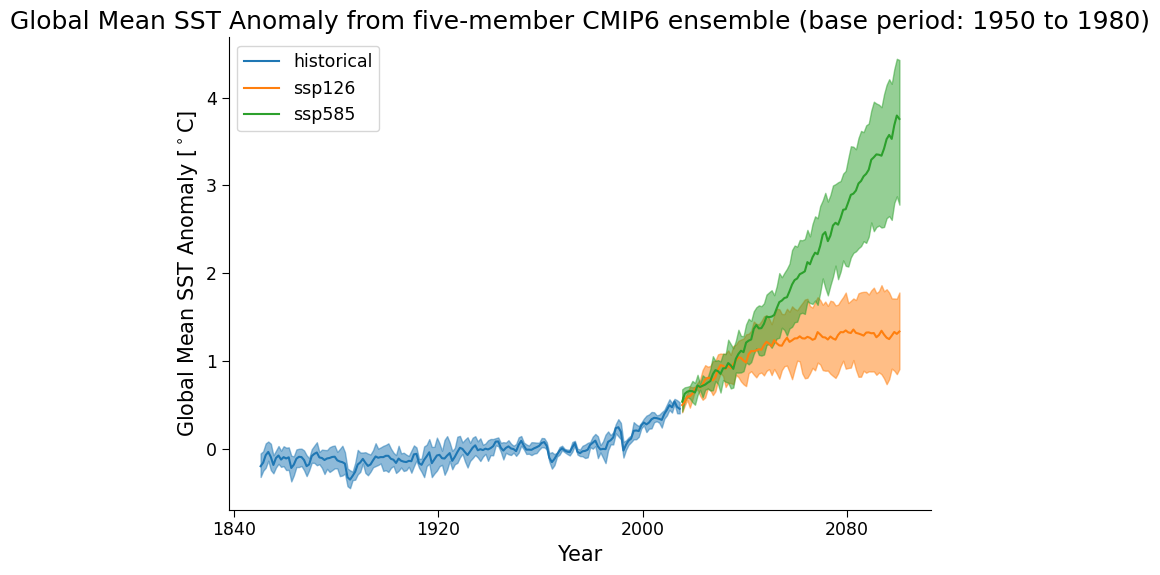

In [25]:
# to_remove solution
fig, ax = plt.subplots()
for experiment, color in zip(["historical", "ssp126", "ssp585"], ["C0", "C1", "C2"]):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_sst = (
            dt_gm_anomaly[model][experiment]
            .ds.tos.coarsen(time=12)
            .mean()
            .assign_coords(source_id=model)
        )
        datasets.append(
            annual_sst.sel(time=slice(None, "2100")).load()
        )  # the french model has a long running member for ssp126
    da = xr.concat(datasets, dim="source_id", join="override").squeeze()
    # Uncomment the below and fill in the ellipses
    # # Calculate the multi-model mean at each time within each experiment
    # da.mean(...).plot(color=color, label=experiment, ax=ax)
    # x = da.time.data
    # # Calculate the lower bound of the likely range
    # da_lower = da.squeeze().quantile(...)
    # # Calculate the upper bound of the likely range
    # da_upper = da.squeeze().quantile(...)
    # ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)
    # Calculate the multi-model mean at each time within each experiment
    da.mean("source_id").plot(color=color, label=experiment, ax=ax)
    x = da.time.data
    # Calculate the lower bound of the likely range
    da_lower = da.squeeze().quantile(0.17, dim="source_id")
    # Calculate the upper bound of the likely range
    da_upper = da.squeeze().quantile(0.83, dim="source_id")
    ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)
ax.set_title(
    "Global Mean SST Anomaly from five-member CMIP6 ensemble (base period: 1950 to 1980)"
)
ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

### Questions 2.1: Climate Connection

1.   What does this figure tell you about how the multi-model uncertainty compares to projected physical changes in the global mean SST? 
2.   Is this the same for both scenarios?
3.   For a 5-model ensemble like this, how do the *likely* ranges specifically relate to the 5 individual model temperatures at a given time?

In [26]:
# to_remove explanation

"""
1. Under both of these scenarios (SSP1-2.6 and SSP5-8.5), the projected warming of the climate is greater than the multi-model uncertainty.
2. The warming is greater for SSP5-8.5, but so is the multi-model uncertainty, so the relative size of physical changes and multi-model uncertainty is comparable across both scenarios.
3. The likely range includes the middle 66% of model results at a given time. For 5 models this means the ranges encompass the middle 3 models (i.e., they exclude the highest and lowest cvalued model at each time).
""";

# Summary
In this tutorial, we have quantified the uncertainty of future climate projections by analyzing variability across a multi-model CMIP6 ensemble. We learned to apply the IPCC's confidence levels to establish a *likely* range of projections, which refers to the middle 66% of model results. 

# Resource

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://wcrp-cmip.org/) multi-model ensemble. 

For examples on how to access and analyze data, please visit the [Pangeo Cloud CMIP6 Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html) 

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).